In [1]:
!pip install -q torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00


In [60]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, json
import pandas as pd
# from torchsummary import summary
# from torchviz import make_dot
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim import Adam, AdamW
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import transforms

# Bagging part
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from joblib import parallel_backend
from sklearn.model_selection import RandomizedSearchCV



import pickle
import torch

In [70]:
# To ensure reproducibility
random.seed(11)
np.random.seed(11)

# To connect to google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA L4


In [5]:
# For avoiding retraining if saved
saved = False

# Preprocessing the data

In [6]:
# Load the dataset
# path = '/kaggle/input/a3-dataset-noaug/'
path = '/content/drive/MyDrive/Colab Notebooks/ECSE551-A3/'
with open(path + 'Train.pkl', 'rb') as f:
    train_x = pickle.load(f, encoding ='bytes')
with open(path + 'Test.pkl', 'rb') as f:
    test_x = pickle.load(f, encoding='bytes')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


train_y = pd.read_csv(path + 'Train_labels.csv', header=None, encoding='latin1').values #new encoding given error?

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


# Flatten label array if needed
train_y_flat = train_y.squeeze()

# Count samples per class
unique, counts = np.unique(train_y_flat, return_counts=True)
class_counts = dict(zip(unique, counts))

print("Total class distribution:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")


# Train validation split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.25,
                                                  random_state=42,stratify=train_y)

print("\nTraining set class distribution:")
unique_train, counts_train = np.unique(y_train.squeeze(), return_counts=True)
for u, c in zip(unique_train, counts_train):
    print(f"Class {u}: {c} samples")

print("\nValidation set class distribution:")
unique_val, counts_val = np.unique(y_val.squeeze(), return_counts=True)
for u, c in zip(unique_val, counts_val):
    print(f"Class {u}: {c} samples")

# Squeeze for NumPy
x_train = x_train.squeeze()
x_val = x_val.squeeze()
x_test = test_x.squeeze()


Total class distribution:
Class 0.0: 5923 samples
Class 1.0: 6742 samples
Class 2.0: 5958 samples
Class 3.0: 6131 samples
Class 4.0: 5842 samples
Class 5.0: 5421 samples
Class 6.0: 5918 samples
Class 7.0: 6265 samples
Class 8.0: 5851 samples
Class 9.0: 5949 samples

Training set class distribution:
Class 0.0: 4442 samples
Class 1.0: 5056 samples
Class 2.0: 4469 samples
Class 3.0: 4598 samples
Class 4.0: 4381 samples
Class 5.0: 4066 samples
Class 6.0: 4439 samples
Class 7.0: 4699 samples
Class 8.0: 4388 samples
Class 9.0: 4462 samples

Validation set class distribution:
Class 0.0: 1481 samples
Class 1.0: 1686 samples
Class 2.0: 1489 samples
Class 3.0: 1533 samples
Class 4.0: 1461 samples
Class 5.0: 1355 samples
Class 6.0: 1479 samples
Class 7.0: 1566 samples
Class 8.0: 1463 samples
Class 9.0: 1487 samples


# Augmentation & Normalization
Augementation is a process we use to help increase performance by training the CNN to identify random variations in the training set!
Normalization increases our performance by restricting the dataset to abide by a certain range of values

In [7]:
augment = True

In [8]:
# Transform the data and normalize it
test_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])


class ImageArrayDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, self.labels[idx]
        return img

if augment:
    transformer = transforms.Compose([
        transforms.ToTensor(),

        transforms.RandomAffine(
            degrees=17,             # mild rotation to simulate handwriting
            translate=(0.15, 0.15), # allow a bit more shift
            scale=(0.9, 1.1),       # simulate size variability
            shear=5                 # mild slanting
        ),
        transforms.ColorJitter(
            brightness=0.2,         # simulate lighting
            contrast=0.2
        ),
        # transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # simulate occlusion
        transforms.Normalize((0.5,), (0.5,))
    ])
else:
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])


train_data = ImageArrayDataset(x_train, y_train, transformer)
val_data = ImageArrayDataset(x_val, y_val, test_transformer)
test_data = ImageArrayDataset(x_test, transform=test_transformer)


In [55]:
# Save to pkl
save_data = True
if save_data:
    with open(path + 'datasets/train_data_aug.pkl', 'wb') as f:
      pickle.dump(train_data, f)
    with open(path + 'datasets/test_data_aug.pkl', 'wb') as f:
      pickle.dump(test_data, f)
    with open(path + 'datasets/val_data_aug.pkl', 'wb') as f:
      pickle.dump(val_data, f)
else:
    with open(path + 'datasets/train_data_aug.pkl', 'rb') as f:
      train_data = pickle.load(f)
    with open(path + 'datasets/test_data_aug.pkl', 'rb') as f:
      test_data = pickle.load(f)
    with open(path + 'datasets/val_data_aug.pkl', 'rb') as f:
      val_data = pickle.load(f)

# Visualize some of the data

(10, 28, 28)


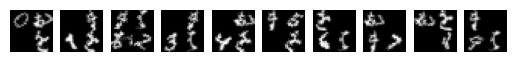

0.9882352948188782 0.0


In [10]:
# Visualize 10 random images
import random
import matplotlib.pyplot as plt

# Put aside an array for the patterns
patterns = np.zeros((10,28,28))

# Set aside one image per class to store (10 images in total)
for category in range(10):
  inclass = [i for i in range(y_train.shape[0]) if y_train[i] == category]
  patterns[category,:] = x_train[inclass[random.randint(0,len(inclass))],:]


print(patterns.shape)

#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:], cmap='gray')
    axs[c].axis("off")
plt.show()

# check the max and min pixel value
print(patterns[0,:].max(), patterns[0,:].min())



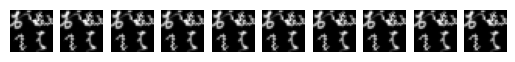

In [11]:
# Print test images
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(test_x[321,:].squeeze(), cmap='gray')
    axs[c].axis("off")
plt.show()

In [12]:
# function print some data
def print_data(data):
  train_loss, val_loss, train_acc, val_acc = data
  print("\nEpoch-wise Performance:")
  print(f"{'Epoch':^5} | {'Train Loss':^10} | {'Val Loss':^10} | {'Train Acc':^10} | {'Val Acc':^10}")
  print("-" * 54)

  for i in range(len(train_loss)):
    print(f"{i:^5} | {train_loss[i]:^10.4f} | {val_loss[i]:^10.4f} | {train_acc[i]:^10.4f} | {val_acc[i]:^10.4f}")

# Classical Machine Learning

We wanted to see first if we can tackle the problem without using deep nets so we chose a classical machine learning method called Bagging, which is a method used to reduce variance.

First, we perform bootstrapping, which consists of creating B subsets (group of samples), from an inital training set. Each subset b contains random elements from the training sample taken with replacement. This means that the same data can appear many times in each set. Then, we train a weak learner model (GausianNB, KNN and Logistic Regression) on each subset separately. Finally, we combine the b outputs and the most popular label will be our final yh. Note that we call those classifiers "weak" becuase they are only trained on random subsets and not the entirety of the training data.

First, we run GuassianNB, KNN and Logistic Regression without tuning any of the hyperparameters.

In [56]:
# Flatten images for sklearn models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Convert labels to 1D
y_train = y_train.ravel()
y_val = y_val.ravel()

In [ ]:
# Define Weak Classifiers
weak_classifiers = {
    "GaussianNB": GaussianNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

# Train and Evaluate Bagging for each classifier
for name, clf in weak_classifiers.items():
    bagging_clf = BaggingClassifier(estimator=clf, n_estimators=10, random_state=42, n_jobs = -1)
    bagging_clf.fit(x_train_flat, y_train)

    # Predict on validation set
    y_pred = bagging_clf.predict(x_val_flat)

    # Compute accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Bagging with {name}: Validation Accuracy = {accuracy:.4f}")

Bagging with GaussianNB: Validation Accuracy = 0.2332
Bagging with LogisticRegression: Validation Accuracy = 0.7883
Bagging with KNN: Validation Accuracy = 0.2498


The values obtained are quite low. (Note that we dropped Logistic Regression for the following code even though it has a decent validation accuracy, this is because it requires more than an hour to run).

## Random Forest

Random Forest is type of bagging that uses decision trees as its base classifier.

In [ ]:
# number of features in each bootstrap subset. Since the value is small, it keeps the decision trees weak
rfc = RandomForestClassifier(n_estimators=5, max_features="sqrt")  # Weak RF

# Random Forest with Grid Search
param_grid = {'n_estimators': [10, 20, 50], 'min_samples_split': [2, 3, 5],
              'criterion': ['gini', 'entropy'], 'max_leaf_nodes': [4, 6, 8]}
gscv = GridSearchCV(rfc, param_grid, cv=3)
gscv.fit(x_train_flat, y_train.ravel())

# Best Random Forest model
rfc_best = gscv.best_estimator_
print("Best Random Forest Classifier:", rfc_best)

# Fit and predict with the best RF model
rfc_best.fit(x_train_flat, y_train.ravel())
y_pred_rf = rfc_best.predict(x_val_flat)

Best Random Forest Classifier: RandomForestClassifier(max_leaf_nodes=8, min_samples_split=5, n_estimators=50)


In [ ]:
acc = accuracy_score(y_val, y_pred_rf)
print(f"random forest Validation Accuracy: {acc:.4f}")

random forest Validation Accuracy: 0.4233


Since the results are quite bad, let's now try to scale the data points. Classifiers such as KNN are quite sensitive to scaling, so hopefully it'll improve the data. We also added GridSearchCV in order to determine the best hyperparameters.

In [ ]:
# Flatten image data for sklearn models
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standardize data
scaler = StandardScaler().fit(x_train_flat)
x_train_scaled = scaler.transform(x_train_flat)
x_val_scaled = scaler.transform(x_val_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Hyperparameter tuning with GridSearchCV
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance']}
param_grid_gnb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
param_grid_lr = {'C': [0.1, 1, 10]}
param_grid_rf = {'n_estimators': [10, 20, 50], 'min_samples_split': [2, 3, 5], 'criterion': ['gini', 'entropy']}

In [ ]:
with parallel_backend('loky'):
    knn_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, n_jobs=-1)
    knn_search.fit(x_train_scaled, y_train)
    best_knn_para = knn_search.best_estimator_
print(f"best knn using parallel processing: {best_knn_para}")

best knn using parallel processing: KNeighborsClassifier(n_neighbors=9, weights='distance')


In [ ]:
with parallel_backend('loky'):
    gnb_search = GridSearchCV(GaussianNB(), param_grid_gnb, n_jobs=-1)
    gnb_search.fit(x_train_scaled, y_train)
    best_gnb_para = gnb_search.best_estimator_
print(f"best gnb using parallel processing: {best_gnb_para}")

best gnb using parallel processing: GaussianNB(var_smoothing=1e-07)


In [ ]:
with parallel_backend('loky'):
  random_search = GridSearchCV(RandomForestClassifier(max_features='sqrt', n_jobs=-1),
                               param_grid_rf, n_jobs=-1)
  random_search.fit(x_train_scaled, y_train)
  best_rf_para = random_search.best_estimator_
print(f"best rf using parallel processing: {best_rf_para}")

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best rf using parallel processing: RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=50, n_jobs=-1)


In [ ]:
# Bagging Classifiers (optimized for memory)
n_estimators = 10  # Reduced from 15-20 to avoid RAM issues (the RAM would spike at 20)
max_samples = 0.7  # Use 70% of data per estimator/bagging subset

# Bagging with weak classifiers
bagging_knn = BaggingClassifier(estimator=best_knn_para, n_estimators=10, max_samples=max_samples, n_jobs=-1) # njobs allows you to optimize runtime
bagging_gnb = BaggingClassifier(estimator=best_gnb_para, n_estimators=10, max_samples=max_samples, n_jobs=-1)
bagging_rf = BaggingClassifier(estimator=best_rf_para, n_estimators=10, max_samples=max_samples, n_jobs=-1)

In [ ]:
models = {
    'Bagging KNN': bagging_knn,
    'Bagging GNB': bagging_gnb,
    'Bagging RF': bagging_rf
}

for name, model in models.items():
    model.fit(x_train_scaled, y_train.ravel())
    y_pred = model.predict(x_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

Bagging KNN Validation Accuracy: 0.2139
Bagging GNB Validation Accuracy: 0.1939


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Bagging RF Validation Accuracy: 0.8429


Now, let's try with more estimators (so more bootstrap subsets)

In [ ]:
# Bagging Classifiers (optimized for memory)
n_estimators = 15  # Reduced from 15-20 to avoid RAM issues
max_samples = 0.7  # Use 70% of data per estimator/ bagging subset

# Bagging with weak classifiers
bagging_knn = BaggingClassifier(estimator=best_knn_para, n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)
bagging_gnb = BaggingClassifier(estimator=best_gnb_para, n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)
bagging_rf = BaggingClassifier(estimator=best_rf_para, n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)

In [ ]:
models = {
    'Bagging KNN': bagging_knn,
    'Bagging GNB': bagging_gnb,
    'Bagging RF': bagging_rf
}

for name, model in models.items():
    model.fit(x_train_scaled, y_train.ravel())
    y_pred = model.predict(x_val_scaled)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")

Bagging KNN Validation Accuracy: 0.2182
Bagging GNB Validation Accuracy: 0.2023
Bagging RF Validation Accuracy: 0.8455


**What** if knn had a lower k like 3 and 5, since that would increase the randomness and keep it more generalized.

In [ ]:
n_estimators = 20
max_samples = 0.7  # Use 70% of data per estimator/ bagging subset
bagging_knn = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)
bagging_knn.fit(x_train_scaled, y_train.ravel())
y_pred = bagging_knn.predict(x_val_scaled)
acc = accuracy_score(y_val, y_pred)
print(f"Bagging KNN with k=5 Validation Accuracy: {acc:.4f}")


bagging_knn = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=3), n_estimators=n_estimators, max_samples=max_samples, n_jobs=-1)
bagging_knn.fit(x_train_scaled, y_train.ravel())
y_pred = bagging_knn.predict(x_val_scaled)
acc = accuracy_score(y_val, y_pred)
print(f"Bagging KNN with k=3 Validation Accuracy: {acc:.4f}")

Bagging KNN with k=5 Validation Accuracy: 0.2119
Bagging KNN with k=3 Validation Accuracy: 0.2013


All these accuracies are quite low (except for the random forest). This suggests that bagging is not a suitable technique for this exercise. Furthermore, KNN might not be suited for image recognition, since it struggles with high dimentionality data; Naive Bayes assumes feature independance, which is not true for images.

# Train, Validate & Test the CNN
Given that our classical ML framework doesn't work, we now proceed with creating some CNNs. Here we setup the training, validation and testing framework of the CNNs.

Before implementing our architectures, we set up a framework for training our neural networls. Our neural networks will be trained using the training set and the validation set will help us to determine when to stop training so that we don't overfit. We then plot our findings and identify the best epoch range. Then based on our best findings we output the CSV file using the test function.

## Train & Validate

In [13]:
saved = False

In [14]:
def train(net, trainset, valset, criterion, optimizer, epochs, size=32, verbose=False):
    val_losses = []
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    counter = 0
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=size,
                                              shuffle=True, num_workers=0)
    train_size = len(trainloader)

    net.train()
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        correct_images = 0
        total_images = 0

        # iterate through batches
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device).type(torch.float32)
            labels = labels.to(device).type(torch.long).squeeze()

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            predicted_label = torch.argmax(outputs, axis=1)
            correct_images += torch.sum(predicted_label == labels)
            total_images += len(labels)

        # Validation
        valloader = torch.utils.data.DataLoader(valset, batch_size=size,
                                                shuffle=True, num_workers=0)
        val_loss = 0.0
        val_correct_images = 0
        val_total_images = 0

        net.eval()
        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                inputs, labels = data
                inputs = inputs.to(device).type(torch.float32)
                labels = labels.to(device).type(torch.long).squeeze()

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted_label = torch.argmax(outputs, axis=1)
                val_correct_images += torch.sum(predicted_label == labels)
                val_total_images += len(labels)

        # Track and optionally print stats
        train_loss = running_loss / train_size
        val_loss_avg = val_loss / len(valloader)
        train_acc = (correct_images / total_images).item()
        val_acc = (val_correct_images / val_total_images).item()

        train_losses.append(train_loss)
        val_losses.append(val_loss_avg)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Added verbose functionality through copilot
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss_avg:.4f} | Val Acc: {val_acc:.4f}")

        if epoch > 2:
            if val_accuracies[-1] - val_accuracies[-2] <= 0.0001:
                counter += 1
                if counter == 3:
                    print('Early stop at epoch: ', epoch + 1)
                    break
            elif val_accuracies[-1] >= 0.9830:
                print('Early stop at epoch: ', epoch + 1)
                break
            else:
                counter = 0

    return train_losses, val_losses, train_accuracies, val_accuracies

## Testing CNN

Finally, we will save the output with the optimized Neural Network hyperparameters.
We found that the following parameters provide the best results based on validation accuracy.



In [15]:
def test(network, testset, batch_size, filename):
    # (Each Batch has 32 Predictions)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    # Record true values
    y_pred = torch.zeros(10000)
    network.eval()
    with torch.no_grad(): # We disable weight updates
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data
            test_images = inputs.to(device)

            # Get the probabilities
            outputs = network(test_images)

            # Update predictions
            start_index = i * batch_size
            finish_index = start_index + inputs.shape[0]
            y_pred[start_index: finish_index] = torch.argmax(outputs, axis=1)


    image_ids = np.arange(1, 10001)

    # Remove last 12 items from perediction

    # Save image_ids y_pred as a csv file with two columns
    df = pd.DataFrame(
        {'id': image_ids,
        'class': y_pred.cpu().numpy().astype(int)}
        )
    df.to_csv(filename + '.csv', index=False)

    return y_pred

## Plotting Loss & Accuracy

In [16]:
# Given the accyracy, losses of validation and training plot them all
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
  fig, axs = plt.subplots(1,2)
  axs[0].plot(train_losses, label='Training Loss')
  axs[0].plot(val_losses, label='Validation Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  axs[1].plot(train_accuracies, label='Training Accuracy')
  axs[1].plot(val_accuracies, label='Validation Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.show()

# Convolutional Neural Networks

## AlexNet

### Model

AlexNet is a classic convolutional neural network originally designed for high-resolution RGB images (224×224×3) in the ImageNet challenge. It consists of stacked convolutional layers with large kernels, max pooling, and fully connected layers at the end.

However, for datasets like MNIST, which contains grayscale images of size 28×28, the original AlexNet is overkill and incompatible due to:

The original AlexNet has 8 layers (5 Convolutional, 3 FC) layers and that's because it needs that level of complexity however this implementation will use 5 layers (3 Convolutional, 2 FC) because having the original kernel sizes and filters didnt make sense as an 11x11 filter would be detrimental on the performance of 28x28 images. Additionally, the pooling layers were an overkill so we reduce these. However what the AlexNet does is that it used Convolution, BatchNorm, ReLu, Pooling and then FC layers and so we use that as an inspiration.

This lightweight version retains the AlexNet flavor but is optimized for small, simple images.
https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In our classification task, we aim to correctly predict which of the 10 classes (digits 0–9) an input image belongs to. For this type of multi-class classification, Cross Entropy Loss is the most appropriate loss function.

Cross Entropy measures the difference between the predicted class probabilities (from the model’s output) and the actual class labels. It penalizes the model more when it’s confident but wrong, and less when it’s unsure but closer to the correct answer.

Mathematically, it combines Log Softmax and Negative Log Likelihood, making it numerically stable and ideal when the model outputs raw scores (logits).

Stochastic Gradient Descent (SGD) is a widely used optimization algorithm that updates model parameters using small batches of data rather than the full dataset. This makes it efficient for large datasets and allows for faster iterations. While it can introduce noisy updates, this often helps escape local minima and improves generalization. Variants like momentum and learning rate schedules are commonly used to improve its performance.

Adam (Adaptive Moment Estimation) is another popular optimizer that combines the benefits of SGD with momentum and adaptive learning rates. It adjusts the learning rate for each parameter individually based on estimates of first and second moments of the gradients, making it well-suited for sparse data and problems with noisy gradients. Adam often converges faster and with less tuning, especially in deep learning tasks.

In [26]:
import torch.nn as nn

class AlexNetwork(nn.Module):
    def __init__(self, function, dropout=0.5):
        super(AlexNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(256, 10)

        # Activation function
        self.activation = function

    def forward(self, x):
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.pool(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [27]:
criterion = nn.CrossEntropyLoss()

### ReLu

In [28]:
# Adam Optimizer
alex_net = AlexNetwork(function=F.relu, dropout=0.3)
alex_net = alex_net.to(device)
sgd = SGD(alex_net.parameters(), lr=0.001,   momentum=0.9)
data = train(alex_net, train_data, val_data, criterion, sgd, 30, verbose=True)
torch.save(alex_net.state_dict(), path+'/mnist_alexReLu.pth')


Epoch 1/30 | Train Loss: 2.2783 | Train Acc: 0.1391 | Val Loss: 2.1250 | Val Acc: 0.2173
Epoch 2/30 | Train Loss: 1.9619 | Train Acc: 0.2944 | Val Loss: 1.1509 | Val Acc: 0.6313
Epoch 3/30 | Train Loss: 1.1940 | Train Acc: 0.5959 | Val Loss: 0.5084 | Val Acc: 0.8376
Epoch 4/30 | Train Loss: 0.8321 | Train Acc: 0.7245 | Val Loss: 0.3562 | Val Acc: 0.8844
Epoch 5/30 | Train Loss: 0.6772 | Train Acc: 0.7798 | Val Loss: 0.2686 | Val Acc: 0.9149
Epoch 6/30 | Train Loss: 0.5914 | Train Acc: 0.8080 | Val Loss: 0.2149 | Val Acc: 0.9340
Epoch 7/30 | Train Loss: 0.5418 | Train Acc: 0.8256 | Val Loss: 0.2117 | Val Acc: 0.9333
Epoch 8/30 | Train Loss: 0.5016 | Train Acc: 0.8381 | Val Loss: 0.1932 | Val Acc: 0.9424
Epoch 9/30 | Train Loss: 0.4768 | Train Acc: 0.8464 | Val Loss: 0.1802 | Val Acc: 0.9444
Epoch 10/30 | Train Loss: 0.4439 | Train Acc: 0.8568 | Val Loss: 0.1747 | Val Acc: 0.9463
Epoch 11/30 | Train Loss: 0.4243 | Train Acc: 0.8639 | Val Loss: 0.1516 | Val Acc: 0.9535
Epoch 12/30 | Train

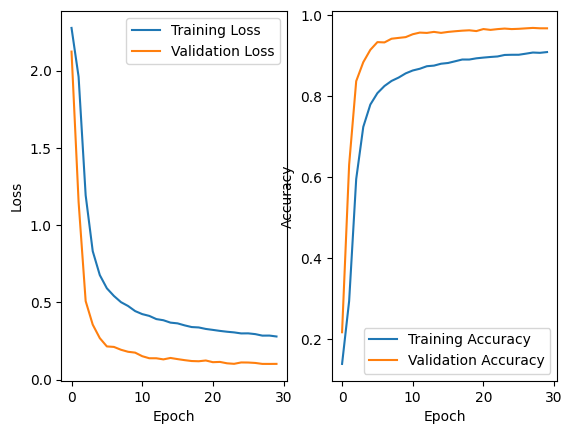

In [29]:
plot_loss_acc(data[0], data[1], data[2], data[3])

### Optimizing Dropout

In [30]:
dropout = [0, 0.3, 0.7]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
an_models = []

for i in dropout:
# Intialize a new net every time to avoid cache training
    new_net = AlexNetwork(function=F.relu, dropout=i)
    new_net = new_net.to(device)
    optimizer = SGD(new_net.parameters(), lr=0.005, momentum=0.6)
    print("Dropout: ", i)
    data = train(new_net, train_data, val_data, criterion, optimizer, 30, size=32, verbose=True)
    an_models.append(new_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))


Dropout:  0
Epoch 1/30 | Train Loss: 2.1572 | Train Acc: 0.2014 | Val Loss: 1.7652 | Val Acc: 0.3633
Epoch 2/30 | Train Loss: 1.5160 | Train Acc: 0.4742 | Val Loss: 0.7523 | Val Acc: 0.7503
Epoch 3/30 | Train Loss: 0.8505 | Train Acc: 0.7214 | Val Loss: 0.4192 | Val Acc: 0.8615
Epoch 4/30 | Train Loss: 0.6370 | Train Acc: 0.7970 | Val Loss: 0.2828 | Val Acc: 0.9121
Epoch 5/30 | Train Loss: 0.5568 | Train Acc: 0.8219 | Val Loss: 0.1974 | Val Acc: 0.9382
Epoch 6/30 | Train Loss: 0.5056 | Train Acc: 0.8370 | Val Loss: 0.2356 | Val Acc: 0.9209
Epoch 7/30 | Train Loss: 0.4630 | Train Acc: 0.8506 | Val Loss: 0.1736 | Val Acc: 0.9467
Epoch 8/30 | Train Loss: 0.4423 | Train Acc: 0.8584 | Val Loss: 0.1462 | Val Acc: 0.9543
Epoch 9/30 | Train Loss: 0.4143 | Train Acc: 0.8670 | Val Loss: 0.1486 | Val Acc: 0.9551
Epoch 10/30 | Train Loss: 0.3998 | Train Acc: 0.8728 | Val Loss: 0.1412 | Val Acc: 0.9572
Epoch 11/30 | Train Loss: 0.3860 | Train Acc: 0.8747 | Val Loss: 0.1420 | Val Acc: 0.9550
Epoch 1

**Dropout 0 = 96.4% Validation Accuracy @ 30 epochs**

**Dropout .3 = 96.8% Validation Accuracy @ 30 epochs**

**Dropout .7 = 97.17% Validation Accuracy @ 30 epochs**

In [36]:
# Save second model as best performing alexnet
torch.save(an_models[2].state_dict(), path+'/mnist_alexnet_model1.pth')

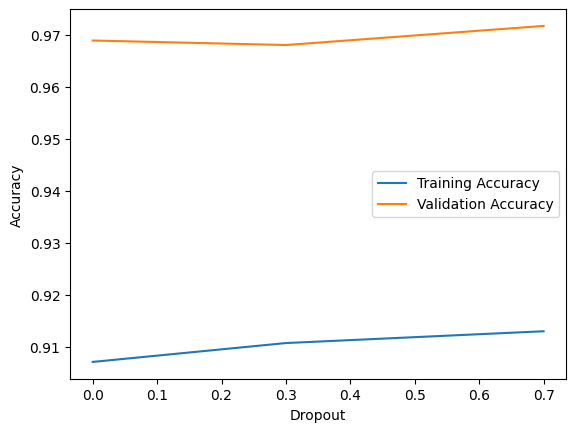

In [31]:
# Plot batch size vs accuracy
plt.plot(dropout, [y for x, y in train_accuracies], label='Training Accuracy')
plt.plot(dropout, [y for x, y in val_accuracies], label='Validation Accuracy')
plt.xlabel('Dropout')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Dropout of 0.6** is optimal

### Optimize LR for SGD

In [ ]:
sgd_lr = [0.003, 0.005, 0.01]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
sgd_an = []
for i in sgd_lr:
# Intialize a new net every time to avoid cache training
    new_net = AlexNetwork(function=F.relu)
    new_net = new_net.to(device)
    sgd = SGD(new_net.parameters(), lr=i, momentum=0.6)
    print("Learning Rate: ", i)
    data = train(new_net, train_data, val_data, criterion, sgd, 30, size=32, verbose=True)
    sgd_an.append(new_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))


Learning Rate:  0.003
Epoch 1/30 | Train Loss: 2.3011 | Train Acc: 0.1208 | Val Loss: 2.2731 | Val Acc: 0.1536
Epoch 2/30 | Train Loss: 2.1562 | Train Acc: 0.2071 | Val Loss: 1.5822 | Val Acc: 0.4681
Epoch 3/30 | Train Loss: 1.5306 | Train Acc: 0.4688 | Val Loss: 0.8742 | Val Acc: 0.6845
Epoch 4/30 | Train Loss: 1.0006 | Train Acc: 0.6637 | Val Loss: 0.5587 | Val Acc: 0.8124
Epoch 5/30 | Train Loss: 0.7807 | Train Acc: 0.7419 | Val Loss: 0.3350 | Val Acc: 0.8931
Epoch 6/30 | Train Loss: 0.6771 | Train Acc: 0.7788 | Val Loss: 0.2770 | Val Acc: 0.9119
Epoch 7/30 | Train Loss: 0.5940 | Train Acc: 0.8066 | Val Loss: 0.2672 | Val Acc: 0.9197
Epoch 8/30 | Train Loss: 0.5434 | Train Acc: 0.8246 | Val Loss: 0.2380 | Val Acc: 0.9255
Epoch 9/30 | Train Loss: 0.5057 | Train Acc: 0.8384 | Val Loss: 0.1936 | Val Acc: 0.9413
Epoch 10/30 | Train Loss: 0.4762 | Train Acc: 0.8461 | Val Loss: 0.2015 | Val Acc: 0.9395
Epoch 11/30 | Train Loss: 0.4486 | Train Acc: 0.8559 | Val Loss: 0.1736 | Val Acc: 0.94

**Learning Rate 0.003 = 96.77% Validation Accuracy @ Epoch 30**

**Learning Rate 0.005 = 96.87% Validation Accuracy @ Epoch 30**

**Learning Rate 0.01 = 96.79% Validation Accuracy @ Epoch 1**

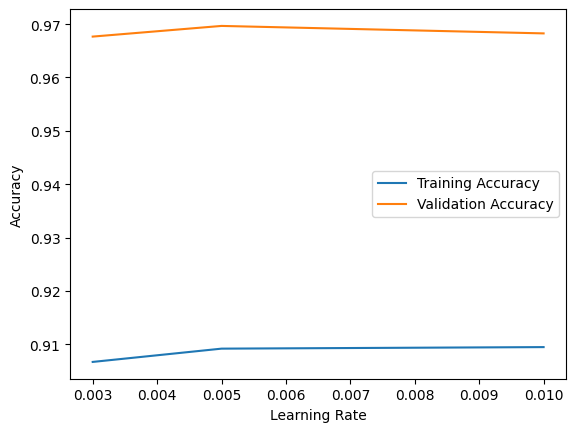

In [34]:
# Plot accuracy vs Learning Rate
plt.plot(sgd_lr, [y for x, y in train_accuracies], label='Training Accuracy')
plt.plot(sgd_lr, [y for x, y in val_accuracies], label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

**We get the best accuracy for SGD using a learning rate of 0.005** with a 96.5% Acccuracy

## LeNet


### Model

https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b

LeNet-5, The original architecture consists of:

	•	2 convolutional layers (with average pooling)

	•	Followed by 3 fully connected layers

	•	Uses tanh activation functions throughout

LeNet was designed to be computationally lightweight and demonstrated the potential of deep learning in image recognition tasks, especially for grayscale images of size 28×28.

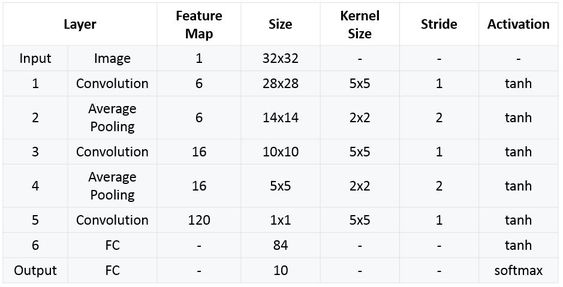

We have to make some modifications to the original network as we want to improve it's performance. The original paper had a 32x32 image as input and so changes must be made to accomodate that. Additionally since this is an old paper, it is now more common to use ReLu as an activation function rather than tanh so we will test that out too.

Our dataset also is not a traditional MNIST dataset, so we need more convolution layers and smaller kernel sizes to capture more details. Additionally the original network used average pooling we will instead use max pooling as it can select features better. We also will also support regularization and normalization as we have seen in class that they usually improve performance

We do this by changing it by convolving twice every single block and using max pooling instead. We will now have 3 convolutional blocks each supporting a convolutional layer, we also do regularization by introducing and optimizing the dropout.

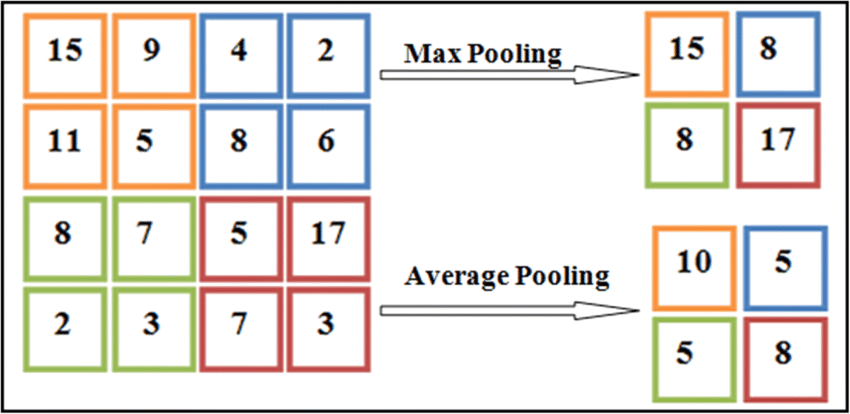

We aim with our new implementation is to do the following

- **Improved Feature Extraction:**
  - More convolutional layers and channels allow for learning more complex and abstract representations.
  
- **Enhanced Training Stability:**
  - Batch Normalization after each convolution layer helps stabilize training and accelerates convergence.
  
- **Regularization:**
  - Dropout before the fully connected layers helps mitigate overfitting by randomly deactivating neurons during training.



In [38]:
import torch.nn as nn

class LeNet6(nn.Module):
    def __init__(self, function, dropout=0.5, num_classes=10):
        super(LeNet6, self).__init__()
        self.activation = function

        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        # Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Block 1
        x = self.activation(self.conv1(x))
        x = self.bn1(x)
        x = self.activation(self.conv2(x))
        x = self.bn2(x)
        x = self.pool(x)

        # Block 2
        x = self.activation(self.conv3(x))
        x = self.bn3(x)
        x = self.activation(self.conv4(x))
        x = self.bn4(x)
        x = self.pool(x)

        # Block 3
        x = self.activation(self.conv5(x))
        x = self.bn5(x)
        x = self.activation(self.conv6(x))
        x = self.bn6(x)
        x = self.pool(x)

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = self.dropout(x)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x

The modified architecture enhances the original LeNet by introducing deeper convolutional layers  with batch normalization to ensure good training. Two max pooling operations effectively downsample the feature maps while preserving key features, and a dropout layer with a 50% rate is incorporated before the fully connected layers to not risk overfitting. The fully connected section is expanded into three layers 625, 84, and 10 units so that we finally reach the 10 digit classification task.

### ReLu

In [ ]:
# Instantiate the model
lenet_6 = LeNet6(function=F.relu)

# Move the model to the GPU if available
lenet_6 = lenet_6.to(device)

# Previous best setting for AlexNet
criterion = nn.CrossEntropyLoss()

optimizer = SGD(lenet_6.parameters(), lr=0.003, momentum=0.9)

data = train(lenet_6, train_data, val_data, criterion, optimizer, 10, verbose=True)
torch.save(lenet_6.state_dict(), path+'/mnist_LeNetReLu.pth')


Epoch 1/30 | Train Loss: 1.8636 | Train Acc: 0.3127 | Val Loss: 0.5725 | Val Acc: 0.8029
Epoch 2/30 | Train Loss: 0.7455 | Train Acc: 0.7677 | Val Loss: 0.2178 | Val Acc: 0.9367
Epoch 3/30 | Train Loss: 0.4826 | Train Acc: 0.8547 | Val Loss: 0.1689 | Val Acc: 0.9500
Epoch 4/30 | Train Loss: 0.4179 | Train Acc: 0.8748 | Val Loss: 0.1346 | Val Acc: 0.9615
Epoch 5/30 | Train Loss: 0.3721 | Train Acc: 0.8855 | Val Loss: 0.1396 | Val Acc: 0.9577
Epoch 6/30 | Train Loss: 0.3495 | Train Acc: 0.8945 | Val Loss: 0.1155 | Val Acc: 0.9679
Epoch 7/30 | Train Loss: 0.3335 | Train Acc: 0.8993 | Val Loss: 0.1129 | Val Acc: 0.9678
Epoch 8/30 | Train Loss: 0.3208 | Train Acc: 0.9012 | Val Loss: 0.1026 | Val Acc: 0.9701
Epoch 9/30 | Train Loss: 0.3080 | Train Acc: 0.9061 | Val Loss: 0.0953 | Val Acc: 0.9727
Epoch 10/30 | Train Loss: 0.2942 | Train Acc: 0.9097 | Val Loss: 0.0960 | Val Acc: 0.9723
Epoch 11/30 | Train Loss: 0.2833 | Train Acc: 0.9134 | Val Loss: 0.0913 | Val Acc: 0.9711
Epoch 12/30 | Train

**Le Net Validation Accuracy LR=0.003 97.27%**

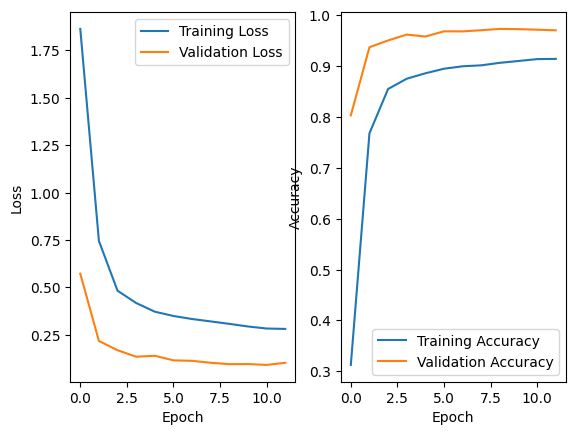

In [ ]:
plot_loss_acc(data[0], data[1], data[2], data[3])

### Optimizing Dropout

In [ ]:
dropout = [0, 0.3, 0.6]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
models_ln = []

for i in dropout:
# Intialize a new net every time to avoid cache training
    new_net = LeNet6(function=F.relu, dropout=i)
    new_net = new_net.to(device)
    optimizer = SGD(new_net.parameters(), lr=0.001, momentum=0.9)

    print("Dropout: ", i)
    data = train(new_net, train_data, val_data, criterion, optimizer, 20, size=32, verbose=True)
    models_ln.append(new_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))


Dropout:  0
Epoch 1/20 | Train Loss: 1.9586 | Train Acc: 0.2800 | Val Loss: 0.8547 | Val Acc: 0.7109
Epoch 2/20 | Train Loss: 0.8611 | Train Acc: 0.7194 | Val Loss: 0.2435 | Val Acc: 0.9271
Epoch 3/20 | Train Loss: 0.5250 | Train Acc: 0.8348 | Val Loss: 0.1853 | Val Acc: 0.9458
Epoch 4/20 | Train Loss: 0.4286 | Train Acc: 0.8678 | Val Loss: 0.1420 | Val Acc: 0.9591
Epoch 5/20 | Train Loss: 0.3881 | Train Acc: 0.8795 | Val Loss: 0.1345 | Val Acc: 0.9611
Epoch 6/20 | Train Loss: 0.3636 | Train Acc: 0.8874 | Val Loss: 0.1219 | Val Acc: 0.9629
Epoch 7/20 | Train Loss: 0.3363 | Train Acc: 0.8951 | Val Loss: 0.1334 | Val Acc: 0.9599
Epoch 8/20 | Train Loss: 0.3294 | Train Acc: 0.8982 | Val Loss: 0.1005 | Val Acc: 0.9687
Epoch 9/20 | Train Loss: 0.3109 | Train Acc: 0.9037 | Val Loss: 0.1059 | Val Acc: 0.9688
Epoch 10/20 | Train Loss: 0.3015 | Train Acc: 0.9049 | Val Loss: 0.1057 | Val Acc: 0.9691
Epoch 11/20 | Train Loss: 0.2960 | Train Acc: 0.9069 | Val Loss: 0.1038 | Val Acc: 0.9689
Epoch 1

**Dropout 0 = 97.67% Validation Accuracy @ 17 epochs**

**Dropout .3 = 97.71% Validation Accuracy @ 18 epochs**

**Dropout .6 = 97.77% Validation Accuracy @ 20 epochs**

In [ ]:
# Le net model accuracy of 97.71, 97.61%
torch.save(models_ln[1].state_dict(), path+'/mnist_lenet_model2.pth')
torch.save(models_ln[0].state_dict(), path+'/mnist_lenet_model3.pth')
torch.save(models_ln[2].state_dict(), path+'/mnist_lenet_model1.pth')

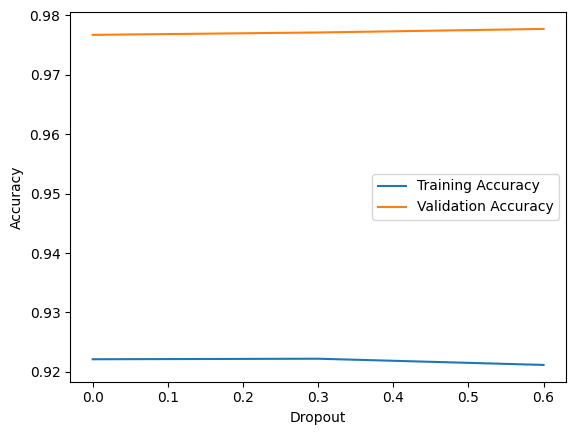

In [ ]:
# Plot batch size vs accuracy
plt.plot(dropout, [y for x, y in train_accuracies], label='Training Accuracy')
plt.plot(dropout, [y for x, y in val_accuracies], label='Validation Accuracy')
plt.xlabel('Dropout')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Optimize LR for SGD

In [ ]:
sgd_lr = [0.001, 0.005, 0.01]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
models_ln_sgd = []
for i in sgd_lr:
# Intialize a new net every time to avoid cache training
    new_net = LeNet6(function=F.relu)
    new_net = new_net.to(device)
    sgd = SGD(new_net.parameters(), lr=i, momentum=0.9)
    print("Learning Rate: ", i)
    data = train(new_net, train_data, val_data, criterion, sgd, 30, size=32, verbose=True)
    models_ln_sgd.append(new_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))


Learning Rate:  0.001
Epoch 1/30 | Train Loss: 2.0886 | Train Acc: 0.2229 | Val Loss: 1.1447 | Val Acc: 0.6031
Epoch 2/30 | Train Loss: 1.0424 | Train Acc: 0.6505 | Val Loss: 0.2959 | Val Acc: 0.9126
Epoch 3/30 | Train Loss: 0.5541 | Train Acc: 0.8285 | Val Loss: 0.1938 | Val Acc: 0.9413
Epoch 4/30 | Train Loss: 0.4589 | Train Acc: 0.8580 | Val Loss: 0.1546 | Val Acc: 0.9535
Epoch 5/30 | Train Loss: 0.4032 | Train Acc: 0.8742 | Val Loss: 0.1330 | Val Acc: 0.9593
Epoch 6/30 | Train Loss: 0.3756 | Train Acc: 0.8842 | Val Loss: 0.1312 | Val Acc: 0.9608
Epoch 7/30 | Train Loss: 0.3505 | Train Acc: 0.8923 | Val Loss: 0.1232 | Val Acc: 0.9629
Epoch 8/30 | Train Loss: 0.3373 | Train Acc: 0.8962 | Val Loss: 0.1231 | Val Acc: 0.9619
Epoch 9/30 | Train Loss: 0.3175 | Train Acc: 0.9009 | Val Loss: 0.1056 | Val Acc: 0.9669
Epoch 10/30 | Train Loss: 0.3084 | Train Acc: 0.9026 | Val Loss: 0.1163 | Val Acc: 0.9636
Epoch 11/30 | Train Loss: 0.2989 | Train Acc: 0.9060 | Val Loss: 0.1035 | Val Acc: 0.96

**Learning Rate 0.001 = 97.69% Validation Accuracy @ Epoch 19**

**Learning Rate 0.005 = 72.49% Validation Accuracy @ Epoch 1**

**Learning Rate 0.01 = 71.97% Validation Accuracy @ Epoch 1**

In [ ]:
# save second model with 97.45%
torch.save(models_ln_sgd[0].state_dict(), path+'/mnist_lenet_model3.pth')

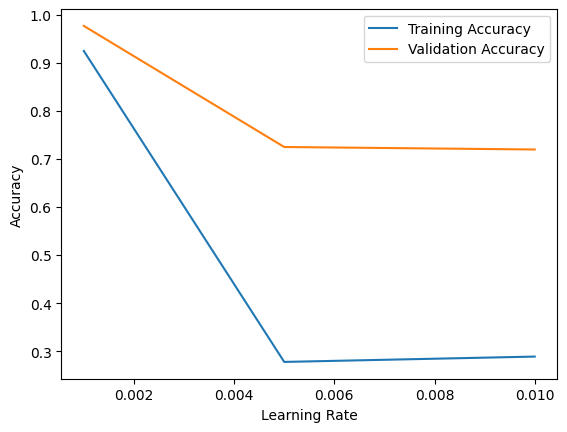

In [ ]:
# Plot accuracy vs Learning Rate
plt.plot(sgd_lr, [y for x, y in train_accuracies], label='Training Accuracy')
plt.plot(sgd_lr, [y for x, y in val_accuracies], label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()

## VGG

### Model

VGG16 is a deep convolutional neural network developed by the Visual Geometry Group at Oxford, recognized for its clean, uniform architecture using 3×3 convolution filters, ReLU activations, and max pooling. It consists of 13 convolutional layers and 3 fully connected layers, originally designed for high-resolution RGB images (224×224×3) in large-scale datasets like ImageNet.

To adapt VGG16 for our smaller dataset with 28x28 images, the architecture itself can remain unchanged by simply modifying the input layer to accept a new shape (e.g., Input(shape=(28, 28, 1))). While the spatial dimensions are smaller, the core design principles of VGG — deep hierarchical feature extraction using small kernels are preserved. This approach retains the original depth and complexity of VGG16, making it suitable for mid-sized inputs while still allowing end-to-end training from scratch or fine-tuning with custom data.

VGG16 includes five MaxPooling layers, each with kernel_size=2 and stride=2, which halves the spatial dimensions at each step. So if we keep our original size of the images we will just shrink to 1x1 really early so we will need to resize our images to 48x48 not 224x224 as the worry is if we resize too much some of our images might lose the latent features that we need in them.

Finally, we will define a new top layer that will classify our images into 10 categories (0-9) so that we can correctly output the labels of our images


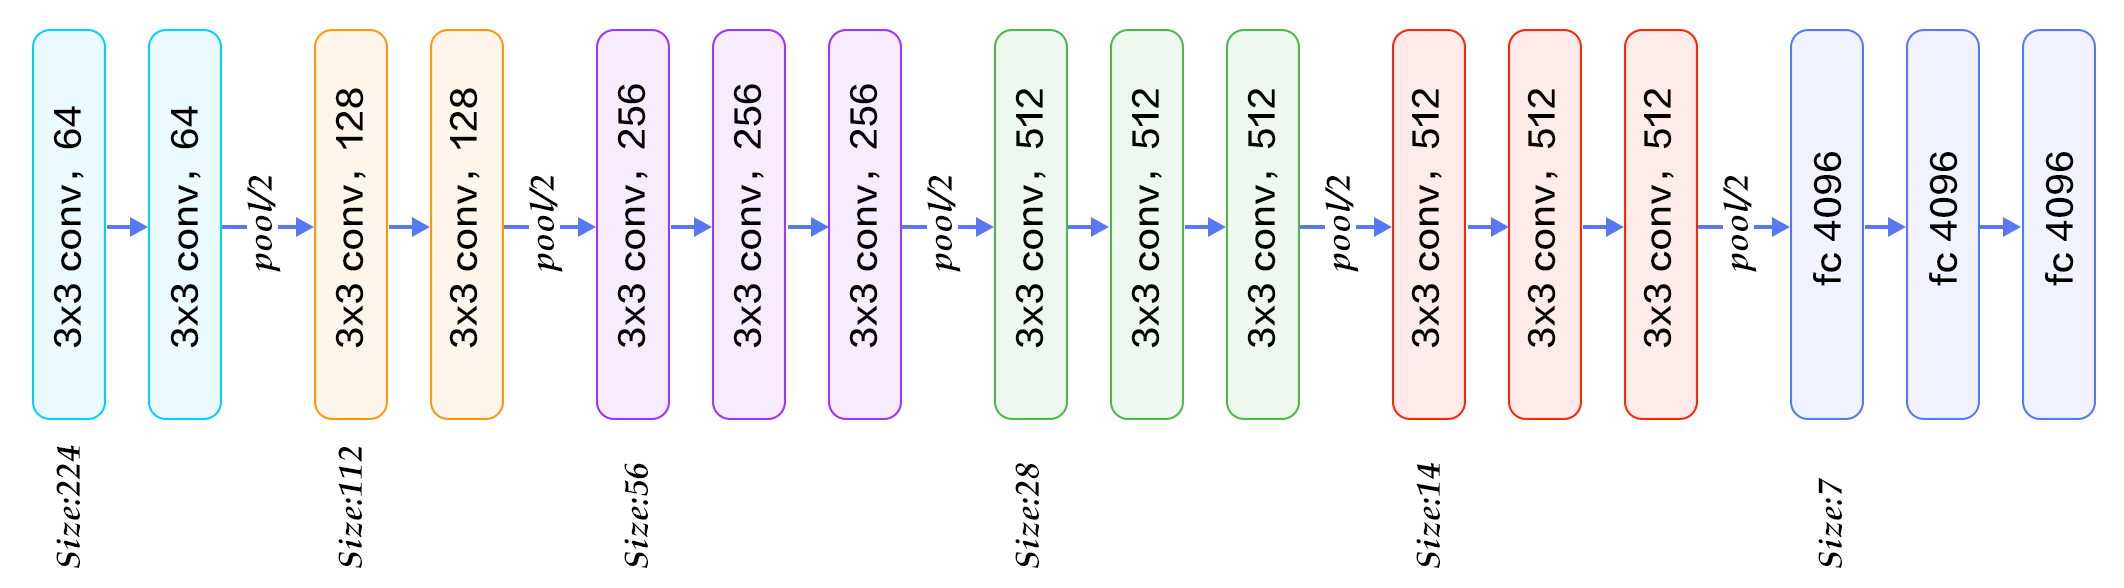

In [17]:
import torch
import torch.nn as nn

class VGG16Grayscale(nn.Module):
    def __init__(self, num_classes=10, dropouting=0.5):
        super(VGG16Grayscale, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28 → 14

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14 → 7

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 7 → 3

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 3 → 1

            # We remove block 5 other wise # 1 → 0
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # 0.5 too aggressive for MNIST
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [18]:
criterion = nn.CrossEntropyLoss()

### ReLu

In [20]:
# Implement the leaky ReLu activation layer
vgg_net1 = VGG16Grayscale()
vgg_net1.to(device)


optimizer11 = SGD(vgg_net1.parameters(), lr=0.003)
data = train(vgg_net1, train_data, val_data, criterion, optimizer11, 21, verbose=True)

Epoch 1/21 | Train Loss: 2.0449 | Train Acc: 0.2352 | Val Loss: 1.2631 | Val Acc: 0.5541
Epoch 2/21 | Train Loss: 1.6968 | Train Acc: 0.3787 | Val Loss: 0.5675 | Val Acc: 0.8311
Epoch 3/21 | Train Loss: 0.5623 | Train Acc: 0.8188 | Val Loss: 0.2302 | Val Acc: 0.9302
Epoch 4/21 | Train Loss: 0.3987 | Train Acc: 0.8710 | Val Loss: 0.2070 | Val Acc: 0.9389
Epoch 5/21 | Train Loss: 0.3344 | Train Acc: 0.8928 | Val Loss: 0.1360 | Val Acc: 0.9591
Epoch 6/21 | Train Loss: 0.2970 | Train Acc: 0.9042 | Val Loss: 0.1766 | Val Acc: 0.9485
Epoch 7/21 | Train Loss: 0.2848 | Train Acc: 0.9090 | Val Loss: 0.1250 | Val Acc: 0.9613
Epoch 8/21 | Train Loss: 0.2621 | Train Acc: 0.9165 | Val Loss: 0.1288 | Val Acc: 0.9625
Epoch 9/21 | Train Loss: 0.2472 | Train Acc: 0.9196 | Val Loss: 0.1007 | Val Acc: 0.9701
Epoch 10/21 | Train Loss: 0.2329 | Train Acc: 0.9242 | Val Loss: 0.1040 | Val Acc: 0.9665
Epoch 11/21 | Train Loss: 0.2245 | Train Acc: 0.9279 | Val Loss: 0.1110 | Val Acc: 0.9658
Epoch 12/21 | Train

**Learning Rate = 0.003 Validation Accuracy 97.71 Epoch 21**

### Optimizing Dropout

In [25]:
# List for different dropout
dropouts = [0, 0.2, 0.3, 0.35, 0.6]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
models = []
for i in dropouts:
    vgg_net = VGG16Grayscale(dropouting=i)
    vgg_net.to(device)
    optimizer = SGD(vgg_net.parameters(), lr=0.003, momentum=0.9)
    print("Dropout: ", i)
    data = train(vgg_net, train_data, val_data, criterion, optimizer, 30, verbose=True)
    models.append(vgg_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))




Dropout:  0
Epoch 1/30 | Train Loss: 1.9182 | Train Acc: 0.2892 | Val Loss: 0.7537 | Val Acc: 0.7460
Epoch 2/30 | Train Loss: 0.8892 | Train Acc: 0.7021 | Val Loss: 0.2693 | Val Acc: 0.9237
Epoch 3/30 | Train Loss: 0.4665 | Train Acc: 0.8589 | Val Loss: 0.1537 | Val Acc: 0.9565
Epoch 4/30 | Train Loss: 0.3873 | Train Acc: 0.8825 | Val Loss: 0.1406 | Val Acc: 0.9591
Epoch 5/30 | Train Loss: 0.3485 | Train Acc: 0.8938 | Val Loss: 0.1245 | Val Acc: 0.9643
Epoch 6/30 | Train Loss: 0.3172 | Train Acc: 0.9032 | Val Loss: 0.1112 | Val Acc: 0.9690
Epoch 7/30 | Train Loss: 0.2982 | Train Acc: 0.9086 | Val Loss: 0.0887 | Val Acc: 0.9729
Epoch 8/30 | Train Loss: 0.2848 | Train Acc: 0.9130 | Val Loss: 0.1020 | Val Acc: 0.9709
Epoch 9/30 | Train Loss: 0.2714 | Train Acc: 0.9154 | Val Loss: 0.0852 | Val Acc: 0.9743
Epoch 10/30 | Train Loss: 0.2583 | Train Acc: 0.9197 | Val Loss: 0.0860 | Val Acc: 0.9746
Epoch 11/30 | Train Loss: 0.2545 | Train Acc: 0.9207 | Val Loss: 0.0804 | Val Acc: 0.9765
Epoch

**Dropout 0 = 98.17% Validation Accuracy @ 29 epochs**

**Dropout .2 = 98.31% Validation Accuracy @ 26 epochs**

**Dropout .3 = 98.40% Validation Accuracy @ 30 epochs**

**Dropout .35= 98.20% Validation Accuracy @ 30 epochs**

**Dropout .6 = 67.81% Validation Accuracy @ 1 epochs**


In [23]:
# Save best models 98.4, 98.31, 98.2
torch.save(models[2].state_dict(), path+'/mnist_vgg_model1.pth')
torch.save(models[1].state_dict(), path+'/mnist_vgg_model2.pth')
torch.save(models[3].state_dict(), path+'/mnist_vgg_model3.pth')

### Optimizing LR for SGD

In [ ]:
sgd_lr = [0.001, 0.005, 0.01]
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []
models_lr = []
for i in sgd_lr:
# Intialize a new net every time to avoid cache training
    vgg_net = VGG16Grayscale()
    vgg_net = vgg_net.to(device)
    sgd = SGD(vgg_net.parameters(), lr=i, momentum=0.6)
    print("Learning Rate: ", i)
    data = train(vgg_net, train_data, val_data, criterion, sgd, 30, size=32, verbose=True)
    models_lr.append(vgg_net)
    train_losses.append((np.argmax(data[0]), data[0][np.argmax(data[0])]))
    val_losses.append((np.argmax(data[1]), data[1][np.argmax(data[1])]))
    train_accuracies.append((np.argmax(data[2]), data[2][np.argmax(data[2])]))
    val_accuracies.append((np.argmax(data[3]), data[3][np.argmax(data[3])]))

Learning Rate:  0.001
Epoch 1/30 | Train Loss: 2.2800 | Train Acc: 0.1366 | Val Loss: 2.1412 | Val Acc: 0.2449
Epoch 2/30 | Train Loss: 1.9139 | Train Acc: 0.3116 | Val Loss: 1.0848 | Val Acc: 0.6256
Epoch 3/30 | Train Loss: 1.0536 | Train Acc: 0.6475 | Val Loss: 0.3809 | Val Acc: 0.8889
Epoch 4/30 | Train Loss: 0.6318 | Train Acc: 0.7992 | Val Loss: 0.2631 | Val Acc: 0.9198
Epoch 5/30 | Train Loss: 0.5127 | Train Acc: 0.8366 | Val Loss: 0.2224 | Val Acc: 0.9311
Epoch 6/30 | Train Loss: 0.4427 | Train Acc: 0.8588 | Val Loss: 0.1785 | Val Acc: 0.9448
Epoch 7/30 | Train Loss: 0.3993 | Train Acc: 0.8739 | Val Loss: 0.1443 | Val Acc: 0.9546
Epoch 8/30 | Train Loss: 0.3775 | Train Acc: 0.8803 | Val Loss: 0.1294 | Val Acc: 0.9607
Epoch 9/30 | Train Loss: 0.3491 | Train Acc: 0.8902 | Val Loss: 0.1233 | Val Acc: 0.9618
Epoch 10/30 | Train Loss: 0.3353 | Train Acc: 0.8934 | Val Loss: 0.1137 | Val Acc: 0.9663
Epoch 11/30 | Train Loss: 0.3181 | Train Acc: 0.8990 | Val Loss: 0.1167 | Val Acc: 0.96

**Learning Rate 0.001 = 96.63% Validation Accuracy @ Epoch 10**

**Learning Rate 0.005 = 98.15% Validation Accuracy @ Epoch 29**

**Learning Rate 0.01 = 43.1% Validation Accuracy @ Epoch 1**

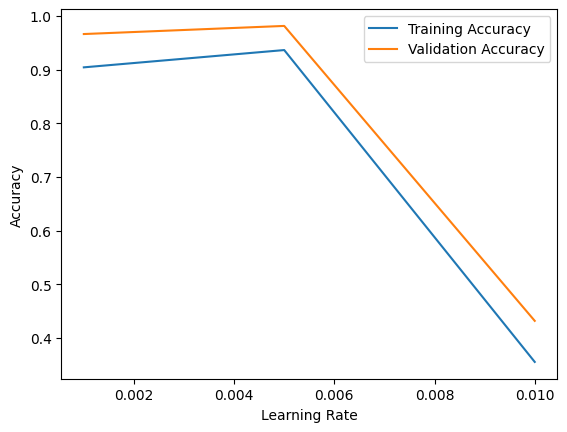

In [ ]:
# Plot learning rate vs accuracy
plt.plot(sgd_lr, [y for x, y in train_accuracies], label='Training Accuracy')
plt.plot(sgd_lr, [y for x, y in val_accuracies], label='Validation Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Ensemble Classification for 3 CNNs

Our VGG outperforms our LeNet function and AlexNet, so we will use 2-4 of the best networks and then use the weaker network like LeNet or AlexNet to be the tiebreaker and so we form a comprehensive classifier with 3 neural networks. Here are the CNNs that we will test

1. VGG **Dropout 0.3, LR=0.003, Batch size = 32, No regularization = 98.40% Validation Accuracy @ 29 epochs**

2. VGG **Dropout 0, LR=0.003, Batch size = 32, No regularization = 98.35%, Validation Accuracy @ 30 epochs**

3. VGG **Dropout .35, LR=0.003, Batch size = 32, No regularization = 98.20% Validation Accuracy @ 30 epochs**

4. LeNet **Dropout .6, LR=0.001, Batch size = 32, No regularization, = 97.77% Validation Accuracy**

5. AlexNet **Dropout .7 LR=0.005, Batch size = 32, No regularization, = 97.17% Validation Accuracy @ 30 epochs**


In [46]:
# Load LeNetVGG
lenet1 = LeNet6(function=F.relu).to(device)
alex1 = AlexNetwork(function=F.relu).to(device)

vgg1 = VGG16Grayscale().to(device)
vgg2 = VGG16Grayscale().to(device)
vgg3 = VGG16Grayscale().to(device)

# Load each CNN
# Switch this to optimized when experiments are done
vgg1.load_state_dict(torch.load(path+'best_models_last_run/mnist_vgg_model1.pth'))
vgg2.load_state_dict(torch.load(path+'best_models_last_run/mnist_vgg_model2.pth'))
vgg3.load_state_dict(torch.load(path+'best_models_last_run/mnist_vgg_model3.pth'))
lenet1.load_state_dict(torch.load(path+'best_models_last_run/mnist_lenet_model1.pth'))
alex1.load_state_dict(torch.load(path+'best_models_last_run/mnist_alexnet_model1.pth'))

<All keys matched successfully>

## Validation Accuracy

In [47]:
criterion = nn.CrossEntropyLoss()

def validate_ensemble(models, val_data, batch_size):
    valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                            shuffle=False, num_workers=0)
    val_loss = 0.0
    val_correct_images = 0
    val_total_images = 0

    for model in models:
        model.eval()

    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long().squeeze()

            outputs = [model(inputs) for model in models]
            preds = [torch.argmax(out, dim=1) for out in outputs]

            # Stack predictions: shape = [N_models, batch_size]
            stacked_preds = torch.stack(preds, dim=0)

            # Majority voting per sample
            voted_preds, _ = torch.mode(stacked_preds, dim=0)

            # Average logits for loss
            avg_outputs = sum(outputs) / len(models)
            loss = criterion(avg_outputs, labels)

            val_loss += loss.item()
            val_correct_images += torch.sum(voted_preds == labels).item()
            val_total_images += len(labels)

    accuracy = 100 * val_correct_images / val_total_images
    avg_loss = val_loss / len(valloader)
    return accuracy, avg_loss


In [71]:
# This was generated using copilot
from itertools import permutations

# List of all your trained models with names
named_models = [
    ('vgg1', vgg1),
    ('vgg2', vgg2),
    ('vgg3', vgg3),
    ('lenet1', lenet1),
    ('alex1', alex1)
]

# Generate all 3-model permutations (order matters)
ordered_combinations = list(permutations(named_models, 3))

# Evaluate each ordered trio
results = []
for (name1, model1), (name2, model2), (name3, model3) in ordered_combinations:
    acc, loss = validate_ensemble([model1, model2, model3], val_data, batch_size=32)
    results.append((f'{name1} + {name2} + {name3}', acc, loss))

# Sort and display top results
results.sort(key=lambda x: x[1], reverse=True)

# Print top 5
print("\n Top 5 for 3-Model Ensemble by Accuracy:\n" + "-"*40)
for name, acc, loss in results[:5]:
    print(f"{name} => Accuracy: {acc:.2f}% | Loss: {loss:.4f}")


 Top 5 for 3-Model Ensemble by Accuracy:
----------------------------------------
vgg1 + vgg2 + vgg3 => Accuracy: 98.61% | Loss: 0.0473
vgg1 + vgg3 + vgg2 => Accuracy: 98.61% | Loss: 0.0473
vgg2 + vgg1 + vgg3 => Accuracy: 98.61% | Loss: 0.0473
vgg2 + vgg3 + vgg1 => Accuracy: 98.61% | Loss: 0.0473
vgg3 + vgg1 + vgg2 => Accuracy: 98.61% | Loss: 0.0473


In [50]:
# 5-Model Ensemble
acc, loss = validate_ensemble([model for _, model in named_models], val_data, 32)
print(f"\nFull 5-Model Ensemble => Accuracy: {acc:.2f}% | Loss: {loss:.4f}")

# 4-Model Ensemble
acc, loss = validate_ensemble([model for _, model in named_models[:4]], val_data, 32)
print(f"\nFull 4-Model Ensemble => Accuracy: {acc:.2f}% | Loss: {loss:.4f}")


Full 5-Model Ensemble => Accuracy: 98.50% | Loss: 0.0487

Full 4-Model Ensemble => Accuracy: 98.34% | Loss: 0.0511


## Kaggle Test

In [52]:
# Ensemble test method
def ensemble_test(cnn1, cnn2, cnn3, test_data1, batch_size, name):
    y_pred1 = test(cnn1, test_data1, batch_size, name + '1')

    # Transform vgg output from tensor into numpy integers
    y_pred1 = y_pred1.cpu().detach().numpy()
    y_pred1 = y_pred1.astype(int)

    y_pred2 = test(cnn2, test_data1, batch_size, name + '2')
    y_pred3 = test(cnn3, test_data1, batch_size, name + '3')

    # Get the majority
    y_pred = []
    for i in range(len(y_pred1)):
        # If they are all equal take the VGG output
        votes = [y_pred1[i], y_pred2[i], y_pred3[i]]
        counts = np.bincount(votes)

        # Check if there's a tie in the vote frequencies
        if (counts == counts.max()).sum() > 1:
        # Tie pick the VGG's prediction
            y_pred.append(y_pred1[i])
        else:
            y_pred.append(np.argmax(counts))

    # Print to CSV file
    image_ids = np.arange(1, 10001)

    # Remove last 12 items from perediction

    # Save image_ids y_pred as a csv file with two columns
    df = pd.DataFrame(
        {'id': image_ids,
        'class': y_pred}
        )
    df.to_csv(name + '.csv', index=False)

    return y_pred


In [69]:
# Ensemble implementation
y_pred = ensemble_test(vgg1, vgg2, vgg3, test_data, 32, path+'final_submission')

We achieve an accuracy of 98.7 percent on the test set through submission on Kaggle

# GAN (Creativity Section)

A **GAN (Generative Adversarial Network)** is a type of neural network that consists of two competing models:

**Pix2Pix** is a type of **Conditional Generative Adversarial Network (cGAN)** designed for **image-to-image translation** tasks.

It works by learning a mapping from **input images** (e.g., noisy MNIST digits) to **output images** (e.g., clean MNIST digits), using paired data.

How it works:

- **Generator**: Learns to map a noisy image to a clean image.
- **Discriminator**: Tries to tell the difference between real clean images and ones generated by the Generator.
- The Generator is trained to **fool the Discriminator** while producing realistic, denoised images.


Pix2Pix uses a combination of:
- **Adversarial Loss** (GAN loss): Makes outputs look realistic.
- **L1 Loss** (Reconstruction loss): Ensures the output is close to the ground truth.

This setup trains a Generator to remove noise from images, making it perfect for handwriting or document restoration tasks.

Our problem here is that we can't match the noisy dataset to the MNIST since it's unordered so we have to create a custom dataset that allows us to do extract a an image from the original MNIST dataset that matches our label.

NOTE: Some of this code was generated using the help of google colabs copilot

In [ ]:
# Load pytorch MNIST dataset
from torchvision import datasets
from torch.utils.data import Dataset
import random
from collections import defaultdict

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=test_transformer)


class NoisyToCleanDataset(Dataset):
    def __init__(self, noisy_data, noisy_labels, clean_dataset):
        self.noisy_data = noisy_data
        self.noisy_labels = noisy_labels
        self.clean_dataset = clean_dataset
        self.label_to_indices = defaultdict(list)
        for idx, (_, label) in enumerate(clean_dataset):
            self.label_to_indices[label].append(idx)

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy = self.noisy_data[idx]
        label = self.noisy_labels[idx].item()

        # Random clean MNIST digit with the same label
        clean_idx = random.choice(self.label_to_indices[label])
        clean_img, _ = self.clean_dataset[clean_idx]


        return noisy, clean_img, label

# Convert numpy to torch
train_x_torch = torch.from_numpy(x_train)
train_y_torch = torch.from_numpy(y_train)

test_x_torch = torch.from_numpy(x_test)

val_x_torch = torch.from_numpy(x_val)
val_y_torch = torch.from_numpy(y_val)

# Our dataset
noisy_clean_dataset = NoisyToCleanDataset(
    noisy_data=train_x_torch,
    noisy_labels=train_y_torch,
    clean_dataset=train_data,
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.64MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 148kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.96MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


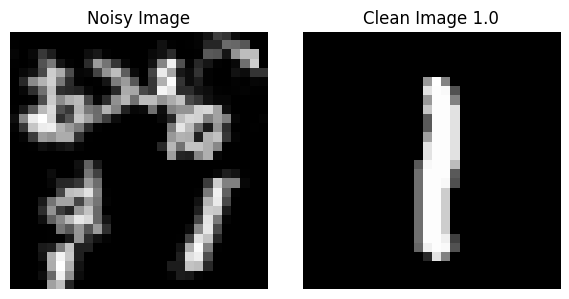

In [ ]:
# Choose a sample to visualize
noisy_img, clean_img, label = noisy_clean_dataset[2]

print(noisy_img.shape, clean_img.shape)

# Plot side-by-side
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(noisy_img.squeeze().cpu(), cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clean_img.squeeze(), cmap='gray')
plt.title(f"Clean Image {label}")
plt.axis('off')

plt.tight_layout()
plt.show()

## Generator


In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder part: noisy image -> latent representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Decoder part: latent representation -> clean image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Discriminator

In [ ]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Training GAN

In [ ]:
def train_gan(gen, disc, trainset, criterion1, criterion2, optimizer_d,
              optimizer_g, epochs, size=32, device='cuda'):
    train_losses = []
    # Loading our dataset
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=size,
                                              shuffle=True, num_workers=0)
    for epoch in range(epochs):
        gen.train()
        disc.train()
        running_d_loss = 0.0
        running_g_loss = 0.0

        for data in trainloader:
            noisy_imgs, clean_imgs, _ = data

            noisy_imgs = noisy_imgs.to(device).float()
            clean_imgs = clean_imgs.to(device).float()
            batch_size = noisy_imgs.size(0)

            valid = torch.full((batch_size, 1), 1.0, device=device)
            fake = torch.full((batch_size, 1), 0.0, device=device)

            # Train Discriminator
            optimizer_d.zero_grad()

            # Real loss - pass only clean images to discriminator
            real_preds = disc(clean_imgs)
            d_real_loss = criterion1(real_preds, valid)

            # Fake loss - generate fake images and pass to discriminator
            fake_imgs = gen(noisy_imgs).detach()  # detach to avoid training generator
            fake_preds = disc(fake_imgs)
            d_fake_loss = criterion1(fake_preds, fake)

            # Total Discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_d.step()

            #  Train Generator
            optimizer_g.zero_grad()

            gen_imgs = gen(noisy_imgs)
            # Pass only generated images to discriminator
            g_adv = criterion1(disc(gen_imgs), valid)
            g_recon = criterion2(gen_imgs, clean_imgs)

            # Balance between adversarial and reconstruction loss
            g_loss = 0.05 * g_adv + g_recon
            g_loss.backward()
            optimizer_g.step()

            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()

        avg_d_loss = running_d_loss / len(trainloader)
        avg_g_loss = running_g_loss / len(trainloader)
        train_losses.append((avg_d_loss, avg_g_loss))

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

        # Optional: Save intermediate models during training
        if (epoch + 1) % 10 == 0:
            torch.save(gen.state_dict(), f"generator_epoch_{epoch+1}.pth")

    return train_losses

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)

criterion1 = nn.BCELoss()
criterion2 = nn.L1Loss()

# Add weight droput due to D becoming really powerful
optimizer_d = AdamW(disc.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=0.0001)
optimizer_g = AdamW(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0)

train_losses = train_gan(gen, disc, noisy_clean_dataset, criterion1, criterion2,
                         optimizer_d, optimizer_g, 10, size=32)

Epoch [1/10] | D Loss: 0.3794 | G Loss: 0.3918
Epoch [2/10] | D Loss: 0.2155 | G Loss: 0.4275
Epoch [3/10] | D Loss: 0.1280 | G Loss: 0.4576
Epoch [4/10] | D Loss: 0.0889 | G Loss: 0.4800
Epoch [5/10] | D Loss: 0.0646 | G Loss: 0.4973
Epoch [6/10] | D Loss: 0.0581 | G Loss: 0.5121
Epoch [7/10] | D Loss: 0.0469 | G Loss: 0.5248
Epoch [8/10] | D Loss: 0.0428 | G Loss: 0.5310
Epoch [9/10] | D Loss: 0.0346 | G Loss: 0.5435
Epoch [10/10] | D Loss: 0.0364 | G Loss: 0.5495


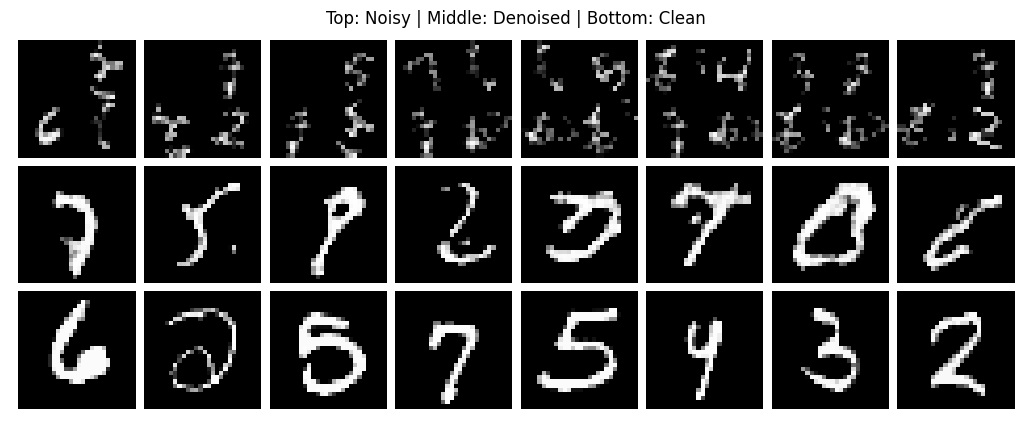

In [ ]:
from torchvision.utils import make_grid, save_image

def visualize_denoising(gen, dataset, num_samples=8, save_path=None):
    gen.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_samples, shuffle=True)

    with torch.no_grad():
        noisy_imgs, clean_imgs, _ = next(iter(dataloader))
        noisy_imgs = noisy_imgs.to(device).float()
        clean_imgs = clean_imgs.to(device).float()
        denoised_imgs = gen(noisy_imgs)

    # Combine all images vertically (noisy, denoised, clean)
    all_imgs = torch.cat([noisy_imgs.cpu(), denoised_imgs.cpu(), clean_imgs.cpu()], dim=0)

    # Create a grid
    grid = make_grid(all_imgs, nrow=num_samples, pad_value=1)

    if save_path:
        save_image(grid, save_path)
        print(f"Saved output to: {save_path}")

    return noisy_imgs.cpu(), denoised_imgs.cpu(), clean_imgs.cpu(), grid

noisy, denoised, clean, grid = visualize_denoising(gen, noisy_clean_dataset, num_samples=8)



plt.figure(figsize=(15, 5))
plt.imshow(grid.permute(1, 2, 0).numpy())  # Convert from CHW → HWC
plt.axis('off')
plt.title("Top: Noisy | Middle: Denoised | Bottom: Clean")
plt.show()

In [ ]:
# Create a dataset that uses your generator to denoise images
class DenoisedDataset(Dataset):
    def __init__(self, original_dataset, labels, generator, device='cuda', transform=None):
        self.original_dataset = original_dataset
        self.labels = labels
        self.generator = generator
        self.device = device
        self.transform = transform

        # Set generator to evaluation mode
        self.generator.eval()

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        noisy_img = self.original_dataset[idx]

        # Denoise the image
        with torch.no_grad():  # No need to track gradients
            noisy_img = noisy_img.to(self.device).float().unsqueeze(0)  # Add batch dimension
            denoised_img = self.generator(noisy_img).squeeze(0)  # Remove batch dimension
            denoised_img = denoised_img.cpu()  # Move back to CPU

        # Apply additional transforms if any
        if self.transform:
            denoised_img = self.transform(denoised_img)

        if self.labels == None:
            return denoised_img

        else:
            return denoised_img, self.labels[idx]



In [ ]:
# Denoised datasets
denoised_train_dataset = DenoisedDataset(
    train_x_torch,
    train_y_torch,
    gen,
    device=device,
    transform=transforms.Normalize((0.5,), (0.5,))  # Adjust normalization as needed
)

# Denoised datasets
denoised_val_dataset = DenoisedDataset(
    val_x_torch,
    val_y_torch,
    gen,
    device=device,
    transform=transforms.Normalize((0.5,), (0.5,))  # Adjust normalization as needed
)

alex3 = AlexNetwork(function=F.leaky_relu).to(device)  # << add .to(device)
optimizer3 = SGD(alex3.parameters(), lr=0.05, weight_decay=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train(alex3, denoised_train_dataset, denoised_val_dataset, criterion, optimizer3, 12, size=16)


Early stop at epoch:  8


([2.305278248866399,
  2.29026598739624,
  2.27715393948555,
  2.260769488096237,
  2.2476279499133427,
  2.2330408089558285,
  2.220162281870842,
  2.206756744424502,
  2.193933140675227],
 [2.308422821044922,
  2.3243694225947062,
  2.3389215116500854,
  2.3428082354863484,
  2.440251361211141,
  2.6010744949976603,
  2.4209248758951825,
  2.395286903063456,
  2.5865903205871583],
 [0.11749999970197678,
  0.12535417079925537,
  0.13718749582767487,
  0.14622916281223297,
  0.15414583683013916,
  0.16108332574367523,
  0.1706041693687439,
  0.179791659116745,
  0.18641667068004608],
 [0.10341666638851166,
  0.11549999564886093,
  0.10391666740179062,
  0.10733333230018616,
  0.10316666215658188,
  0.09808333218097687,
  0.09341666847467422,
  0.09883332997560501,
  0.09441666305065155])

In [ ]:
denoised_test_dataset = DenoisedDataset(
        test_x_torch,
        None,
        gen,
        device=device,
        transform=transforms.Normalize((0.5,), (0.5,))
)

test(alex3, denoised_test_dataset, 16, 'gan')


tensor([3., 3., 0.,  ..., 0., 3., 0.])